# Metagenome classification for Veseli et al. 2023

This Jupyter notebook contains the code related to metagenome classification in our study. Given our observation that certain KEGG modules are enriched in fecal metagenomes from individuals with inflammatory bowel disease (IBD), we wanted to test whether we could use metabolism data to differentiate between samples from healthy individuals and samples from those with IBD. We therefore trained logistic regression models to classify samples as either 'healthy' or 'IBD', using the per-population copy numbers (PPCN) of the IBD-enriched modules as features of the classifier.

We tested our classification strategy using cross-validation (CV). In each CV fold, we computed the set of IBD-enriched pathways _de novo_ from the training data, using the same strategy as we did earlier in the paper when analyzing the full dataset. We ran CV with several different methods for splitting the data:

* Leave Two Studies Out CV (to test study-specific effects)
* Random CV (to evaulate overall performance)
* Random CV but without the samples from the two dominating studies in our dataset, Le Chatelier 2013 and Vineis 2016 (to check whether the metabolism differences are coming from these two dominant cohorts, or whether the signal is consistent across all studies)

We then used our entire dataset to train a final classifier, which we tested on the intermediate non-IBD sample group and on an external antibiotic time-series dataset from Palleja et al. 

# Leave-Two-Out Cross-Validation

Here, I will run my entire pipeline using leave-two-studies-out CV.

The data will be normalized (per-population) copy numbers, henceforth referred to as PPCN, of KEGG modules in IBD and Healthy gut metagenome assemblies. The pipeline will include:

1. splitting the data into train and test sets where the test will include one IBD study and one Healthy study
2. computing per-module group medians (for computing effect size)
3. running a per-module one-sided Wilcox test for IBD PPCN > Healthy PPCN and saving the p-value
4. computing group median differences (IBD median - Healthy median) for each module
5. selecting the set of IBD-enriched modules with p-value <= 1e-10 (equivalent to our FDR-adjusted threshold of 2e-10) and group median difference greater than the mean group median difference
6. training a Logistic Regression classifier to identify IBD vs Healthy using the PPCN of the IBD-enriched modules
7. testing that classifier on the two studies that were left out and recording the performance.

I can also run this later using random train-test splits, which do not take into account sample's study of origin.

In [1]:
# imports
import os
import random
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import wilcoxon # paired
from scipy.stats import ranksums # unpaired
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_curve

In [2]:
# relevant directories
data_dir = "TRAINING_DATA/"
output_dir = "CLASSIFIER_OUTPUT/"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [3]:
# IBD vs Healthy studies
HEALTHY_STUDIES = ["Chatelier_2013", "Feng_2015", "Raymond_2015", "University_of_Sydney_2016", "Wen_2017", "Xie_2016"]
IBD_STUDIES = ["Franzosa_2018", "Lloyd-Price_2019", "Schirmir_2018", "Vineis_2016"]

## Functions

In [4]:
def get_labels_as_integer(str_target_data):
    """Takes a dataframe of per-sample labels as strings and converts to a list of integers."""
    
    return [1 if x == 'IBD' else 2 if x == 'NONIBD' else 0 for x in str_target_data]

In [5]:
def get_integer_labels_as_str(int_target_data):
    """Takes a list of integer labels and converts to a list of string labels."""
    
    return ['IBD' if x == 1 else 'NONIBD' if x == 2 else 'HEALTHY' for x in int_target_data]

In [6]:
def split_data_L2O(samples_info, feature_data, target_data):
    """Returns all possible train-test splits of the data where each test split contains one IBD study 
    and one Healthy study.
    
    Returned as a dictionary of dictionaries, where the outer dictionary is keyed by integer (split number)
    and the inner dictionary contains the following:
    - train_x: features of training set
    - train_y: labels of training set
    - test_x: features of test set
    - test_y: labels of test set
    
    We also return split_info, a DataFrame containing for each split
        - healthy_study: which healthy study is being left out of the training data
        - ibd_study: which IBD study is being left out of the training data
        - num_test_samples: size of test set
        - num_test_healthy: number of healthy samples in test set
        - num_test_IBD: number of IBD samples in test set
        - num_train_samples: size of training set
        - num_train_healthy: number of healthy samples in training set
        - num_train_IBD: number of IBD samples in training set
    """
    
    split_info_rows = ["healthy_study", "ibd_study", "num_test_samples", "num_test_healthy", "num_test_IBD",
                       "num_train_samples", "num_train_healthy", "num_train_IBD"]
    split_info = pd.DataFrame(index=split_info_rows, columns=[x for x in range(len(HEALTHY_STUDIES)*len(IBD_STUDIES))])
    
    cv_split = {}
    split_num = 0
    for h_study in HEALTHY_STUDIES:
        for i_study in IBD_STUDIES:
            split_info.loc["healthy_study", split_num] = h_study
            split_info.loc["ibd_study", split_num] = i_study
            
            h_samples = samples_info[samples_info['study'] == h_study].index
            i_samples = samples_info[samples_info['study'] == i_study].index
            test_samples = h_samples.union(i_samples)

            split_info.loc["num_test_samples", split_num] = len(test_samples)
            split_info.loc["num_test_healthy", split_num] = len(h_samples)
            split_info.loc["num_test_IBD", split_num] = len(i_samples)

            test_x = feature_data.loc[test_samples]
            test_labels = target_data.loc[test_samples]
            test_y = get_labels_as_integer(test_labels)
            assert(test_y.count(1) == len(i_samples))

            train_x = feature_data.drop(test_samples)
            train_labels = target_data.drop(test_samples)
            train_y = get_labels_as_integer(train_labels)
            assert(train_y.count(1) == len(train_labels[train_labels == "IBD"]))

            # ensure features are in matching order as labels
            train_x = train_x.loc[train_labels.index]
            test_x = test_x.loc[test_labels.index]

            split_info.loc["num_train_samples", split_num] = train_x.shape[0]
            split_info.loc["num_train_healthy", split_num] = len(train_labels[train_labels == "HEALTHY"])
            split_info.loc["num_train_IBD", split_num] = len(train_labels[train_labels == "IBD"])
            
            cv_split[split_num] = {}
            cv_split[split_num]["train_x"] = train_x
            cv_split[split_num]["train_y"] = train_labels
            cv_split[split_num]["test_x"] = test_x
            cv_split[split_num]["test_y"] = test_labels
            
            split_num += 1
            
    return cv_split, split_info

In [7]:
def compute_group_medians_and_stats(train_data_x, train_data_y):
    """Returns a dataframe of the group medians, group median differences, and Wilcoxon p-value 
    for IBD PPCN > Healthy PPCN, for each KEGG module, in the training data.
    """
    
    data = train_data_x
    data['label'] = train_data_y
    
    # group medians
    df = pd.melt(data, id_vars=['label'], ignore_index=False)
    grouped_df = df.groupby(['module', 'label']).median().unstack()
    
    # median differences
    grouped_df['DIFF'] = grouped_df['value']['IBD'] - grouped_df['value']['HEALTHY']
    
    # per-module Wilcoxon test for IBD PPCN > Healthy PPCN
    grouped_df['P_VALUE'] = ""
    for mod in grouped_df.index:
        mod_data_ibd_samples = df[(df['module'] == mod) & (df['label'] == 'IBD')]['value']
        mod_data_healthy_samples = df[(df['module'] == mod) & (df['label'] == 'HEALTHY')]['value']
        stat, p_value = ranksums(mod_data_ibd_samples, mod_data_healthy_samples, 
                         alternative='greater')
        grouped_df.loc[mod, 'P_VALUE'] = p_value
        
    grouped_df.sort_values(by = ['P_VALUE', 'DIFF'], axis=0, ascending=[True, False], inplace=True)
    
    return grouped_df

In [8]:
def get_ibd_enriched_modules(module_stats, pval_threshold = 1e-10, min_median_diff = 0):
    """Uses per-module statistics obtained from compute_group_medians_and_stats() to compute 
    IBD-enriched modules and return these as a list.
    
    Criteria for module selection:
    - p-value from Wilcoxon rank-sums test <= pval_threshold
    - group median difference (IBD - Healthy) >= mean(median differences) or min_median_diff, whichever is larger
    """
    
    mean_median_diff = module_stats['DIFF'].mean()
    diff_threshold = max(mean_median_diff, min_median_diff)
    
    ibd_enriched_mods = module_stats[(module_stats['DIFF'] >= diff_threshold) & 
                                     (module_stats['P_VALUE'] <= pval_threshold)].index
    
    if not len(ibd_enriched_mods):
        print(f"WARNING: no IBD-enriched modules in this dataset using p-value threshold of  <= {pval_threshold} "
              f"and group median difference threshold of >= {diff_threshold}.")
        
    return ibd_enriched_mods, diff_threshold
    

In [9]:
def subset_mods(mods_to_subset, train_x, test_x):
    """Returns a subset of the train-test dataframes containing only the modules in mods_to_subset."""
    
    subset_train_x = train_x[mods_to_subset]
    subset_test_x = test_x[mods_to_subset]
    
    return subset_train_x, subset_test_x
    

In [10]:
def train_test_LR_model(train_x, train_y, test_x, test_y, model_name=0, random_state=323):
    """Returns a trained model and its performance on the test set."""
    
    train_y_int = get_labels_as_integer(train_y)
    test_y_int = get_labels_as_integer(test_y)
    
    model = LogisticRegression(penalty=None, max_iter=20000, random_state=random_state)
    trained_model = model.fit(train_x, train_y_int)
    
    pred = trained_model.predict(test_x)
    y_score = trained_model.predict_proba(test_x)
    
    # SCORE
    accuracy = metrics.accuracy_score(test_y_int, pred)
    roc_auc = metrics.roc_auc_score(test_y_int, pred)
    f1 = metrics.f1_score(test_y_int, pred)
    cm = metrics.confusion_matrix(test_y_int, pred)
    fpr, tpr, thresholds = roc_curve(test_y_int, y_score[:, 1])
    
    results = {}
    results["Accuracy"] = accuracy
    results["ROC_AUC"] = roc_auc
    results["F1_score"] = f1
    results["True_Healthy"] = cm[0][0]
    results["False_IBD"] = cm[0][1]
    results["False_Healthy"] = cm[1][0]
    results["True_IBD"] = cm[1][1]
    results["FPR_ROC_curve_vals"] = fpr
    results["TPR_ROC_curve_vals"] = tpr
    
    results_df = pd.DataFrame.from_dict(results, orient='index', columns=[model_name])
    
    return trained_model, results_df

In [11]:
# credit for this solution:
# https://stats.stackexchange.com/questions/186337/average-roc-for-repeated-10-fold-cross-validation-with-probability-estimates

def plot_ROC_curve_for_CV(all_FPRs_list, all_TPRs_list, path_to_save):
    """Plots an ROC curve for each fold and an interpolated 'mean' curve"""
    all_interpolated_tprs = []
    base_fpr = np.linspace(0, 1, 101)

    plt.figure(figsize=(10, 10))
    plt.axes().set_aspect('equal', 'datalim')

    for fpr,tpr in zip(all_FPRs_list, all_TPRs_list):
        if not (isinstance(fpr, np.ndarray)) and np.isnan(fpr):
            print("FPR list is NaN, skipping...")
            continue

        plt.plot(fpr, tpr, '#15616d', alpha=0.15)
        interpolated_tpr = np.interp(base_fpr, fpr, tpr)
        interpolated_tpr[0] = 0.0
        all_interpolated_tprs.append(interpolated_tpr)

    all_interpolated_tprs = np.array(all_interpolated_tprs)
    mean_tprs = all_interpolated_tprs.mean(axis=0)
    std = all_interpolated_tprs.std(axis=0)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std


    plt.plot(base_fpr, mean_tprs, '#15616d', label="Mean performance")
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3, label="Confidence interval")

    plt.plot([0, 1], [0, 1],'#cc998d',linestyle='dashed', label="Naive Classifier")
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc="lower right")
    plt.savefig(path_to_save)
    
    plt.show()
    

## Load Data

In [12]:
# labels
samples = pd.read_csv(data_dir + "00_SUBSET_SAMPLES_INFO.txt", sep='\t', index_col=0)
subset_samples = samples[samples['group'].isin(['HEALTHY', 'IBD'])]
subset_target = subset_samples['group']

In [13]:
# raw data
## number of estimated populations
num_pops_subset = subset_samples['num_populations']

## stepwise copy number
copy_num_matrix = pd.read_csv(data_dir + "METAGENOME_METABOLISM-module_stepwise_copy_number-MATRIX.txt", \
                                     sep='\t', index_col=0)
subset_copy_num_matrix = copy_num_matrix[subset_samples.index]

# PPCN features
subset_normalized = subset_copy_num_matrix / num_pops_subset
subset_ppcn = subset_normalized.T
# put samples in feature matrix in same order as target matrix
subset_ppcn = subset_ppcn.loc[subset_target.index]

## Run L2O CV

In [14]:
split_data_dict, split_info_df = split_data_L2O(subset_samples, subset_ppcn, subset_target)

In [15]:
performance_df_list = []
for split_num, split in split_data_dict.items():
    print(f"Training on split {split_num}")
    train_features = split['train_x']
    train_labels = split['train_y']
    test_features = split['test_x']
    test_labels = split['test_y']

    medians = compute_group_medians_and_stats(train_features, train_labels)
    ibd_enriched_modules, median_threshold = get_ibd_enriched_modules(medians)
    split_info_df.loc["median_diff_threshold", split_num] = median_threshold
    split_info_df.loc["num_IBD_enriched_mods", split_num] = len(ibd_enriched_modules)
    if len(ibd_enriched_modules) == 0:
        print(f"WARNING: no enriched modules found for split {split_num} of the data, skipping model training.")
        continue

    train_mods, test_mods = subset_mods(ibd_enriched_modules, train_features, test_features)
    # below, we use the same random state for each fold to ensure changes in performance only come from changes
    # in the data used for training and not from model initialization
    LR_model, single_performance_df = train_test_LR_model(train_mods, train_labels, test_mods, test_labels, 
                                                   model_name=split_num, random_state=711)
    performance_df_list.append(single_performance_df)

Training on split 0
Training on split 1
Training on split 2
Training on split 3
Training on split 4
Training on split 5
Training on split 6
Training on split 7
Training on split 8
Training on split 9
Training on split 10
Training on split 11
Training on split 12
Training on split 13
Training on split 14
Training on split 15
Training on split 16
Training on split 17
Training on split 18
Training on split 19
Training on split 20
Training on split 21
Training on split 22
Training on split 23


In [16]:
# combine performance dfs with split info
all_performances = pd.concat(performance_df_list, axis=1)
L2O_results = pd.concat([split_info_df, all_performances], axis=0)
L2O_results.loc["True IBD Rate"] = L2O_results.loc["True_IBD"] / L2O_results.loc["num_test_IBD"]
L2O_results.loc["True Healthy Rate"] = L2O_results.loc["True_Healthy"] / L2O_results.loc["num_test_healthy"]

In [17]:
# extract info for ROC curve
all_FPRs = L2O_results.loc["FPR_ROC_curve_vals"].to_list()
all_TPRs = L2O_results.loc["TPR_ROC_curve_vals"].to_list()

# drop from results frame
L2O_results = L2O_results.drop(["FPR_ROC_curve_vals", "TPR_ROC_curve_vals"])

In [18]:
pd.set_option("display.max_columns", None)
L2O_results

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
healthy_study,Chatelier_2013,Chatelier_2013,Chatelier_2013,Chatelier_2013,Feng_2015,Feng_2015,Feng_2015,Feng_2015,Raymond_2015,Raymond_2015,Raymond_2015,Raymond_2015,University_of_Sydney_2016,University_of_Sydney_2016,University_of_Sydney_2016,University_of_Sydney_2016,Wen_2017,Wen_2017,Wen_2017,Wen_2017,Xie_2016,Xie_2016,Xie_2016,Xie_2016
ibd_study,Franzosa_2018,Lloyd-Price_2019,Schirmir_2018,Vineis_2016,Franzosa_2018,Lloyd-Price_2019,Schirmir_2018,Vineis_2016,Franzosa_2018,Lloyd-Price_2019,Schirmir_2018,Vineis_2016,Franzosa_2018,Lloyd-Price_2019,Schirmir_2018,Vineis_2016,Franzosa_2018,Lloyd-Price_2019,Schirmir_2018,Vineis_2016,Franzosa_2018,Lloyd-Price_2019,Schirmir_2018,Vineis_2016
num_test_samples,181,154,155,215,59,32,33,93,52,25,26,86,38,11,12,72,47,20,21,81,32,5,6,66
num_test_healthy,151,151,151,151,29,29,29,29,22,22,22,22,8,8,8,8,17,17,17,17,2,2,2,2
num_test_IBD,30,3,4,64,30,3,4,64,30,3,4,64,30,3,4,64,30,3,4,64,30,3,4,64
num_train_samples,149,176,175,115,271,298,297,237,278,305,304,244,292,319,318,258,283,310,309,249,298,325,324,264
num_train_healthy,78,78,78,78,200,200,200,200,207,207,207,207,221,221,221,221,212,212,212,212,227,227,227,227
num_train_IBD,71,98,97,37,71,98,97,37,71,98,97,37,71,98,97,37,71,98,97,37,71,98,97,37
median_diff_threshold,0.037143,0.030982,0.03179,0.017464,0.062662,0.056501,0.057308,0.042982,0.067257,0.061096,0.061903,0.047577,0.062581,0.05642,0.057227,0.042901,0.065163,0.059002,0.05981,0.045484,0.063086,0.056925,0.057732,0.043406
num_IBD_enriched_mods,25,29,30,0,49,51,51,4,47,51,53,2,46,49,49,1,46,52,53,2,46,50,50,1


In [19]:
L2O_results.iloc[10:,].mean(axis=1, skipna=True)

Accuracy              0.601193
ROC_AUC               0.588694
F1_score              0.431623
True_Healthy         27.217391
False_IBD             6.043478
False_Healthy        10.739130
True_IBD             12.826087
True IBD Rate         0.420290
True Healthy Rate     0.757098
dtype: float64

FPR list is NaN, skipping...


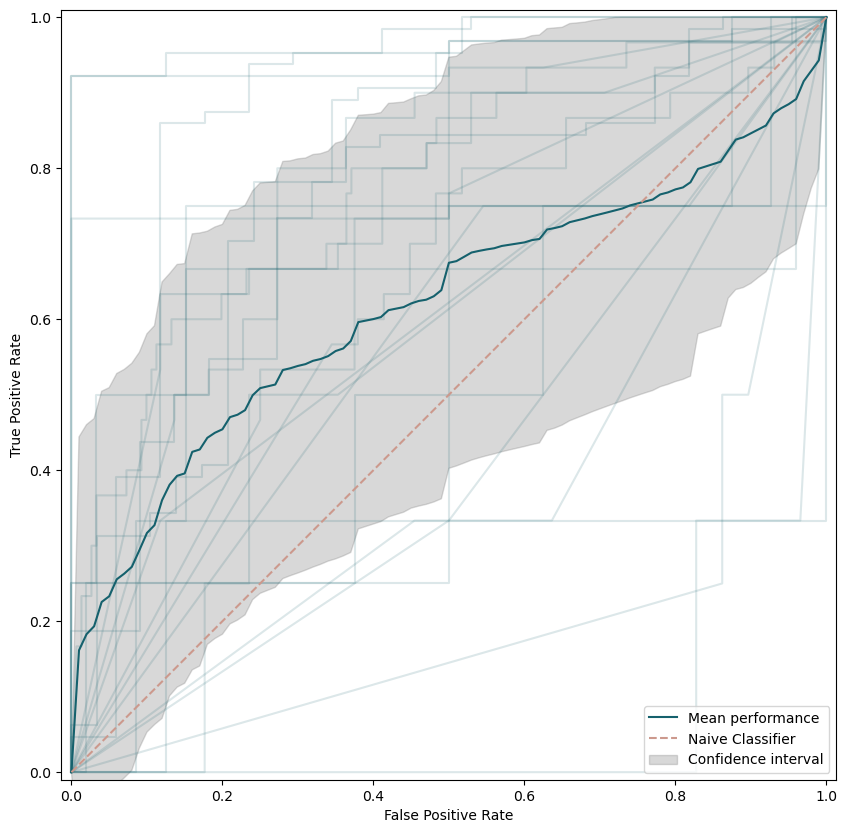

In [20]:
# make ROC curve
plot_ROC_curve_for_CV(all_FPRs, all_TPRs, output_dir + "L20_CV_ROC_curve.svg")

# Random Cross-Validation

Here, I will run my entire pipeline using random CV. This will evaluate the overall performance of our classification strategy.

The pipeline will include:

1. splitting the data randomly into train and test sets, where the train set includes 80% of the data
2. computing per-module group medians
3. running a per-module one-sided Wilcox test for IBD PPCN > Healthy PPCN and saving the p-value
4. computing group median differences (IBD median - Healthy median) for each module
5. selecting the set of IBD-enriched modules with p-value <= 1e-10 (equivalent to our FDR-adjusted p-value threshold of p <= 2e-10) and with group median difference greater than the mean group median difference
6. training a Logistic Regression classifier to identify IBD vs Healthy using the PPCN of the IBD-enriched modules
7. testing that classifier on the 20% of the data in the test set and recording the performance.

Thus, the features in each fold will be selected independently of the test set.

## Additional Functions

In [21]:
def split_data_random(samples_info, feature_data, target_data, num_splits=10, percent_test=0.2, random_seed=1452):
    """Returns num_splits random train-test splits of the data.
    
    Returned as a dictionary of dictionaries, where the outer dictionary is keyed by integer (split number)
    and the inner dictionary contains the following:
    - train_x: features of training set
    - train_y: labels of training set
    - test_x: features of test set
    - test_y: labels of test set
    
    We also return split_info, a DataFrame containing for each split
        - num_test_samples: size of test set (set by percent_test)
        - num_test_healthy: number of healthy samples in test set
        - num_test_IBD: number of IBD samples in test set
        - num_train_samples: size of training set
        - num_train_healthy: number of healthy samples in training set
        - num_train_IBD: number of IBD samples in training set
    """
    
    split_info_rows = ["num_test_samples", "num_test_healthy", "num_test_IBD",
                       "num_train_samples", "num_train_healthy", "num_train_IBD"]
    split_info = pd.DataFrame(index=split_info_rows, columns=[x for x in range(num_splits)])
    
    cv_split = {}
    for split_num in range(num_splits):
        test_samples = target_data.sample(frac=percent_test, replace=False, random_state=random_seed * split_num).index
        test_x = feature_data.loc[test_samples]
        test_labels = target_data.loc[test_samples]

        split_info.loc["num_test_samples", split_num] = len(test_samples)
        split_info.loc["num_test_healthy", split_num] = len(test_labels[test_labels == 'HEALTHY'])
        split_info.loc["num_test_IBD", split_num] = len(test_labels[test_labels == 'IBD'])

        train_x = feature_data.drop(test_samples)
        train_labels = target_data.drop(test_samples)
        
        split_info.loc["num_train_samples", split_num] = train_x.shape[0]
        split_info.loc["num_train_healthy", split_num] = len(train_labels[train_labels == "HEALTHY"])
        split_info.loc["num_train_IBD", split_num] = len(train_labels[train_labels == "IBD"])

        # ensure features are in matching order as labels
        train_x = train_x.loc[train_labels.index]
        test_x = test_x.loc[test_labels.index]

        cv_split[split_num] = {}
        cv_split[split_num]["train_x"] = train_x
        cv_split[split_num]["train_y"] = train_labels
        cv_split[split_num]["test_x"] = test_x
        cv_split[split_num]["test_y"] = test_labels

        split_num += 1
            
    return cv_split, split_info

## Run Random CV

In [22]:
split_data_dict, split_info_df = split_data_random(subset_samples, subset_ppcn, subset_target, 
                                                   num_splits=25, percent_test=0.2, random_seed=15)

In [23]:
split_info_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
num_test_samples,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66
num_test_healthy,50,46,50,47,46,52,46,53,40,47,50,44,44,41,47,39,44,45,40,43,45,46,48,47,48
num_test_IBD,16,20,16,19,20,14,20,13,26,19,16,22,22,25,19,27,22,21,26,23,21,20,18,19,18
num_train_samples,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264
num_train_healthy,179,183,179,182,183,177,183,176,189,182,179,185,185,188,182,190,185,184,189,186,184,183,181,182,181
num_train_IBD,85,81,85,82,81,87,81,88,75,82,85,79,79,76,82,74,79,80,75,78,80,81,83,82,83


In [24]:
performance_df_list = []
for split_num, split in split_data_dict.items():
    print(f"Training on split {split_num}")
    train_features = split['train_x']
    train_labels = split['train_y']
    test_features = split['test_x']
    test_labels = split['test_y']

    medians = compute_group_medians_and_stats(train_features, train_labels)
    ibd_enriched_modules, median_threshold = get_ibd_enriched_modules(medians)
    split_info_df.loc["median_diff_threshold", split_num] = median_threshold
    split_info_df.loc["num_IBD_enriched_mods", split_num] = len(ibd_enriched_modules)
    if len(ibd_enriched_modules) == 0:
        print(f"WARNING: no enriched modules found for split {split_num} of the data, skipping model training.")
        continue

    train_mods, test_mods = subset_mods(ibd_enriched_modules, train_features, test_features)
    # below, we use the same random state for each fold to ensure changes in performance only come from changes
    # in the data used for training and not from model initialization
    LR_model, single_performance_df = train_test_LR_model(train_mods, train_labels, test_mods, test_labels, 
                                                   model_name=split_num, random_state=711)
    performance_df_list.append(single_performance_df)

Training on split 0
Training on split 1
Training on split 2
Training on split 3
Training on split 4
Training on split 5
Training on split 6
Training on split 7
Training on split 8
Training on split 9
Training on split 10
Training on split 11
Training on split 12
Training on split 13
Training on split 14
Training on split 15
Training on split 16
Training on split 17
Training on split 18
Training on split 19
Training on split 20
Training on split 21
Training on split 22
Training on split 23
Training on split 24


In [25]:
# combine performance dfs with split info
all_performances = pd.concat(performance_df_list, axis=1)
RCV_results = pd.concat([split_info_df, all_performances], axis=0)
RCV_results.loc["True IBD Rate"] = RCV_results.loc["True_IBD"] / RCV_results.loc["num_test_IBD"]
RCV_results.loc["True Healthy Rate"] = RCV_results.loc["True_Healthy"] / RCV_results.loc["num_test_healthy"]

In [26]:
# extract info for ROC curve
all_FPRs = RCV_results.loc["FPR_ROC_curve_vals"].to_list()
all_TPRs = RCV_results.loc["TPR_ROC_curve_vals"].to_list()

# drop from results frame
RCV_results = RCV_results.drop(["FPR_ROC_curve_vals", "TPR_ROC_curve_vals"])

In [27]:
RCV_results

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
num_test_samples,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66
num_test_healthy,50,46,50,47,46,52,46,53,40,47,50,44,44,41,47,39,44,45,40,43,45,46,48,47,48
num_test_IBD,16,20,16,19,20,14,20,13,26,19,16,22,22,25,19,27,22,21,26,23,21,20,18,19,18
num_train_samples,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264
num_train_healthy,179,183,179,182,183,177,183,176,189,182,179,185,185,188,182,190,185,184,189,186,184,183,181,182,181
num_train_IBD,85,81,85,82,81,87,81,88,75,82,85,79,79,76,82,74,79,80,75,78,80,81,83,82,83
median_diff_threshold,0.057006,0.055536,0.057905,0.051696,0.057638,0.054046,0.053497,0.051762,0.061677,0.059305,0.058385,0.051638,0.050932,0.055998,0.057667,0.055341,0.055744,0.05999,0.051969,0.053883,0.055206,0.058919,0.058034,0.05842,0.061581
num_IBD_enriched_mods,43,42,46,42,44,46,43,40,50,48,48,39,37,41,48,43,44,48,37,40,45,48,47,45,50
Accuracy,0.909091,0.909091,0.848485,0.848485,0.878788,0.863636,0.818182,0.939394,0.848485,0.818182,0.712121,0.848485,0.909091,0.924242,0.863636,0.818182,0.863636,0.772727,0.909091,0.909091,0.80303,0.893939,0.878788,0.787879,0.833333
ROC_AUC,0.8975,0.906522,0.7725,0.799552,0.856522,0.835165,0.798913,0.904209,0.821154,0.762598,0.6825,0.829545,0.875,0.907805,0.857223,0.806268,0.840909,0.744444,0.891346,0.91001,0.779365,0.867391,0.864583,0.788354,0.798611


In [28]:
RCV_results.iloc[8:,].mean(axis=1)

Accuracy              0.856364
ROC_AUC               0.831920
F1_score              0.762075
True_Healthy         41.080000
False_IBD             4.840000
False_Healthy         4.640000
True_IBD             15.440000
True IBD Rate         0.768108
True Healthy Rate     0.895731
dtype: float64

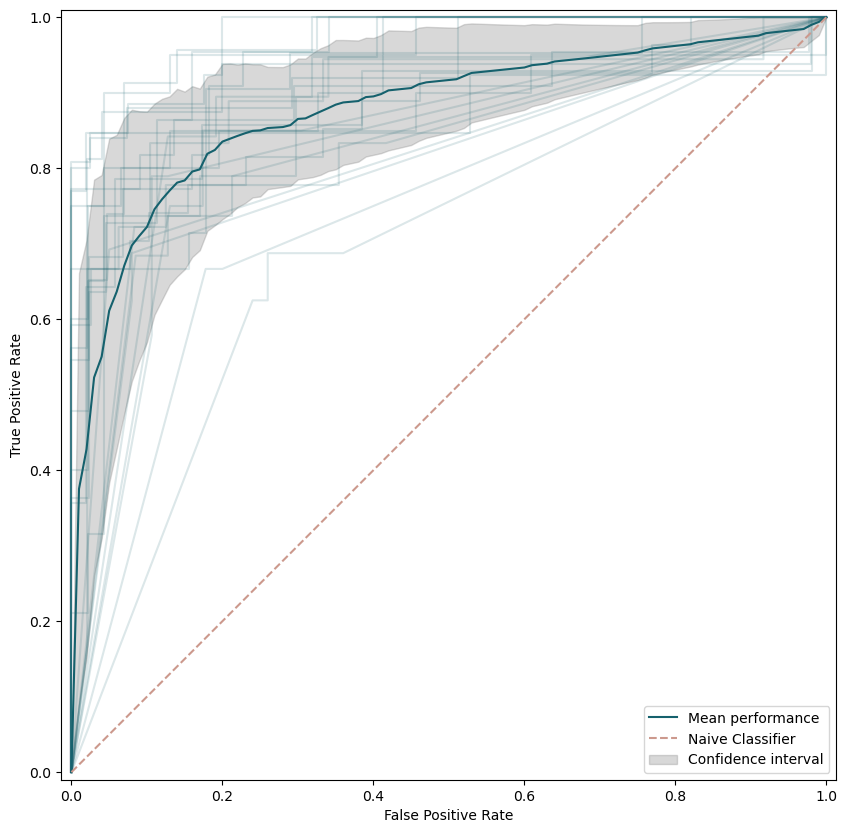

In [29]:
# make ROC curve
plot_ROC_curve_for_CV(all_FPRs, all_TPRs, output_dir + "RANDOM_CV_ROC_curve.svg")

# Leave Out Chatelier/Vineis Samples Cross-Validation

Here I'm going to train a model using the 33 IBD-enriched modules as features, and run cross-validation on the set of samples excluding the Chatelier et al and Vineis et al samples (which represent the largest portion of the samples above). As these studies have proportionally-large influence on the selection of the IBD-enriched modules, successful classification results here will indicate that there is still some IBD-enrichment signal for these 33 modules in the remaining samples. 

## Load 33 IBD-enriched modules and set features

In [30]:
ibd_enriched_modules = pd.read_csv(data_dir + "IBD_ENRICHED_MODULES.txt", sep='\t')['module'].to_list()

In [32]:
ibd_ppcn = subset_ppcn[ibd_enriched_modules]

## Take out Chatelier/Vineis Samples

In [32]:
samples_to_keep = subset_samples[(subset_samples['study'] != 'Chatelier_2013') & 
                                  (subset_samples['study'] != 'Vineis_2016')].index
kept_samples = subset_samples.loc[samples_to_keep]
kept_target = subset_target.loc[samples_to_keep]

In [33]:
kept_features = ibd_ppcn.loc[samples_to_keep]

## Run 10-fold CV

In [34]:
split_data_dict, split_info_df = split_data_random(kept_samples, kept_features, kept_target, 
                                                   num_splits=10, percent_test=0.2, random_seed=1937)

In [35]:
split_info_df

,0,1,2,3,4,5,6,7,8,9
num_test_samples,23,23,23,23,23,23,23,23,23,23
num_test_healthy,14,13,12,16,17,11,16,17,16,16
num_test_IBD,9,10,11,7,6,12,7,6,7,7
num_train_samples,92,92,92,92,92,92,92,92,92,92
num_train_healthy,64,65,66,62,61,67,62,61,62,62
num_train_IBD,28,27,26,30,31,25,30,31,30,30


In [36]:
performance_df_list = []
for split_num, split in split_data_dict.items():
    print(f"Training on split {split_num}")
    train_features = split['train_x']
    train_labels = split['train_y']
    test_features = split['test_x']
    test_labels = split['test_y']

    # below, we use the same random state for each fold to ensure changes in performance only come from changes
    # in the data used for training and not from model initialization
    LR_model, single_performance_df = train_test_LR_model(train_features, train_labels, test_features, test_labels, 
                                                   model_name=split_num, random_state=234)
    performance_df_list.append(single_performance_df)

Training on split 0
Training on split 1
Training on split 2
Training on split 3
Training on split 4
Training on split 5
Training on split 6
Training on split 7
Training on split 8
Training on split 9


In [37]:
# combine performance dfs with split info
all_performances = pd.concat(performance_df_list, axis=1)
CV_results = pd.concat([split_info_df, all_performances], axis=0)
CV_results.loc["True IBD Rate"] = CV_results.loc["True_IBD"] / CV_results.loc["num_test_IBD"]
CV_results.loc["True Healthy Rate"] = CV_results.loc["True_Healthy"] / CV_results.loc["num_test_healthy"]

In [38]:
# extract info for ROC curve
all_FPRs = CV_results.loc["FPR_ROC_curve_vals"].to_list()
all_TPRs = CV_results.loc["TPR_ROC_curve_vals"].to_list()

# drop from results frame
CV_results = CV_results.drop(["FPR_ROC_curve_vals", "TPR_ROC_curve_vals"])

In [39]:
CV_results

,0,1,2,3,4,5,6,7,8,9
num_test_samples,23,23,23,23,23,23,23,23,23,23
num_test_healthy,14,13,12,16,17,11,16,17,16,16
num_test_IBD,9,10,11,7,6,12,7,6,7,7
num_train_samples,92,92,92,92,92,92,92,92,92,92
num_train_healthy,64,65,66,62,61,67,62,61,62,62
num_train_IBD,28,27,26,30,31,25,30,31,30,30
Accuracy,0.782609,0.695652,0.652174,0.521739,0.652174,0.521739,0.782609,0.695652,0.695652,0.652174
ROC_AUC,0.781746,0.719231,0.651515,0.575893,0.495098,0.530303,0.803571,0.794118,0.620536,0.549107
F1_score,0.736842,0.72,0.636364,0.47619,0.2,0.421053,0.705882,0.631579,0.461538,0.333333
True_Healthy,11,7,8,7,14,8,12,10,13,13


In [40]:
CV_results.iloc[6:,].mean(axis=1)

Accuracy              0.665217
ROC_AUC               0.652112
F1_score              0.532278
True_Healthy         10.300000
False_IBD             4.500000
False_Healthy         3.200000
True_IBD              5.000000
True IBD Rate         0.609986
True Healthy Rate     0.694238
dtype: float64

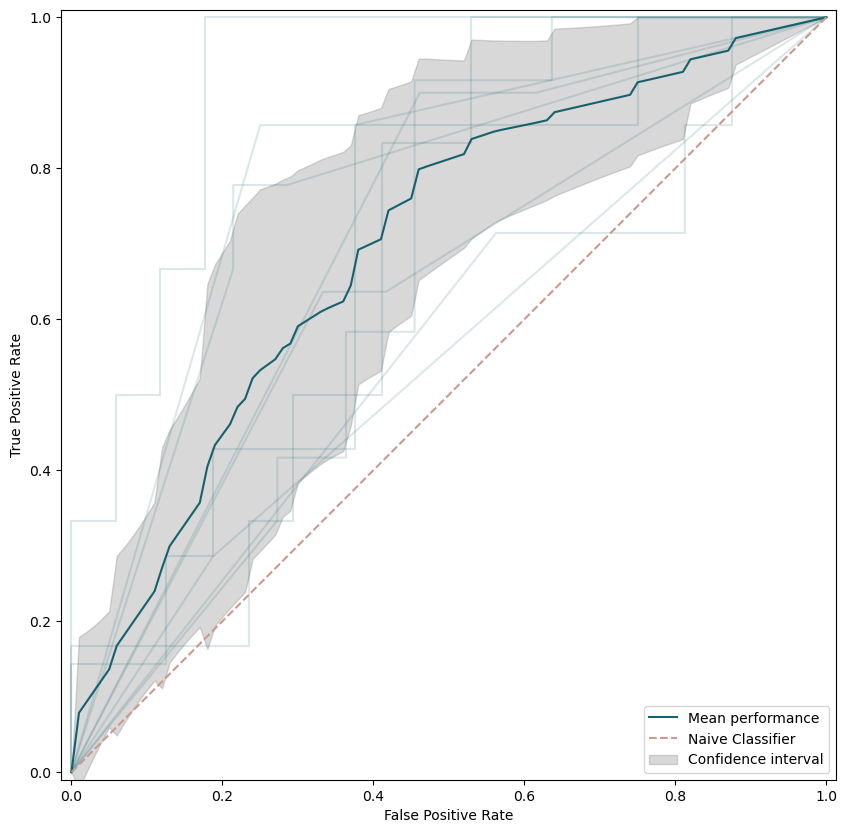

In [41]:
# make ROC curve
plot_ROC_curve_for_CV(all_FPRs, all_TPRs, output_dir + "NO_CHATELIER_VINEIS_ROC_curve.svg")

# Train Final Classifier

Here, I train a final classifier using the 33 IBD-enriched modules on all 330 samples in the set.

In [42]:
final_target = subset_target
final_features = ibd_ppcn.loc[final_target.index]

In [43]:
final_y_int = get_labels_as_integer(final_target)
    
final_model = LogisticRegression(penalty=None, max_iter=20000, random_state=1511)
final_trained_model = final_model.fit(final_features, final_y_int)

In [44]:
# store classifier model
pickle.dump(final_model, open("classifier.pickle", 'wb'))

In [45]:
# make sure we can load the model again
final_model = pickle.load(open("classifier.pickle", 'rb'))

# Test on Non-IBD Samples

## Load Data

In [47]:
# labels
nonibd_samples = samples.loc[samples['group'] == 'NONIBD']

In [45]:
# raw data
## number of estimated populations
num_pops_nonibd = nonibd_samples['num_populations']

## stepwise copy number
nonibd_copy_num = copy_num_matrix[nonibd_samples.index]

# keep only IBD-enriched modules as features
nonibd_ibd_mods = nonibd_copy_num.loc[ibd_enriched_modules]

# PPCN features
nonibd_normalized = nonibd_ibd_mods / num_pops_nonibd
nonibd_ppcn = nonibd_normalized.T


## Test

In [46]:
pred = final_model.predict(nonibd_ppcn)
nonibd_predictions = pd.DataFrame(pred, index=nonibd_ppcn.index, columns=["class"])

In [47]:
nonibd_predictions['class'].value_counts()

0    66
1    12
Name: class, dtype: int64

In [48]:
# class predictions by study for NONIBD samples
nonibd_predictions['study'] = nonibd_samples['study']
nonibd_predictions.groupby('study')['class'].value_counts()

study          class
Feng_2015      0        53
               1        12
Franzosa_2018  0        11
Schirmir_2018  0         2
Name: class, dtype: int64

In [49]:
# class predictions by diagnosis for NONIBD samples
nonibd_predictions['diagnosis'] = nonibd_samples['diagnosis']
nonibd_predictions.groupby('diagnosis')['class'].value_counts()

diagnosis      class
CRC_ADENOMA    0        27
               1         4
CRC_CARCINOMA  0        26
               1         8
HEALTHY        0        13
Name: class, dtype: int64

# Test on Antibiotic Time-Series Samples

Here we test the final classifier on samples from [Palleja et al 2018](https://www.nature.com/articles/s41564-018-0257-9).

## Load Data

In [102]:
antibiotics_data_dir = "TESTING_DATA/"
antibiotics_module_matrix = pd.read_csv(antibiotics_data_dir + "antibiotics-module_stepwise_copy_number-MATRIX.txt", \
                                        sep="\t", index_col=0)
antibiotics_samples = pd.read_csv(antibiotics_data_dir + "02_PALLEJA_SAMPLES_INFO.txt", \
                                        sep="\t", index_col=0)

## number of estimated populations
antibiotics_num_pops = antibiotics_samples['num_populations']

# keep only IBD-enriched modules as features
antibiotics_ibd = antibiotics_module_matrix.loc[ibd_enriched_modules]
# compute PPCN
antibiotics_normalized = antibiotics_ibd / antibiotics_num_pops
antibiotics_ppcn = antibiotics_normalized.T

In [103]:
# get number of reads per sample
num_reads_matrix = antibiotics_samples[['r1_num_reads','r2_num_reads']]

## Test

In [104]:
pred = final_model.predict(antibiotics_ppcn)
antibiotics_predictions = pd.DataFrame(pred, index=antibiotics_ppcn.index, columns=["class"])
antibiotics_predictions[['Subject','Day']] = antibiotics_predictions.index.str.split("_").to_list()

In [105]:
antibiotics_predictions['Low_Seq_Depth'] = (num_reads_matrix['r1_num_reads'] < 25000000) | (num_reads_matrix['r2_num_reads'] < 25000000)

In [106]:
antibiotics_predictions.loc[antibiotics_predictions['class'] == 1, 'class'] = 'IBD'
antibiotics_predictions.loc[antibiotics_predictions['class'] == 0, 'class'] = 'HEALTHY'

In [107]:
antibiotics_predictions

,class,Subject,Day,Low_Seq_Depth
ERAS10_Day0,HEALTHY,ERAS10,Day0,False
ERAS10_Day180,HEALTHY,ERAS10,Day180,False
ERAS10_Day42,HEALTHY,ERAS10,Day42,False
ERAS10_Day8,IBD,ERAS10,Day8,True
ERAS11_Day0,HEALTHY,ERAS11,Day0,False
ERAS11_Day180,HEALTHY,ERAS11,Day180,False
ERAS11_Day42,HEALTHY,ERAS11,Day42,True
ERAS11_Day4opt,HEALTHY,ERAS11,Day4opt,False
ERAS11_Day8,IBD,ERAS11,Day8,True
ERAS12_Day0,HEALTHY,ERAS12,Day0,False


In [108]:
antibiotics_predictions.groupby(['Day', 'class']).size()

Day      class  
Day0     HEALTHY    12
Day180   HEALTHY    11
         IBD         1
Day4     HEALTHY     3
Day42    HEALTHY     8
         IBD         4
Day4opt  HEALTHY     3
         IBD         3
Day8     HEALTHY     2
         IBD         8
Day8opt  IBD         2
dtype: int64

In [109]:
antibiotics_predictions.groupby(['Day', 'Low_Seq_Depth', 'class']).size()

Day      Low_Seq_Depth  class  
Day0     False          HEALTHY    11
         True           HEALTHY     1
Day180   False          HEALTHY    11
                        IBD         1
Day4     False          HEALTHY     3
Day42    False          HEALTHY     6
                        IBD         4
         True           HEALTHY     2
Day4opt  False          HEALTHY     3
                        IBD         2
         True           IBD         1
Day8     False          HEALTHY     1
                        IBD         6
         True           HEALTHY     1
                        IBD         2
Day8opt  False          IBD         2
dtype: int64

In [110]:
antibiotics_predictions.to_csv(output_dir + "CLASSIFIER_PREDICTIONS.txt", sep="\t", index_label='sample')

# Final Model Feature Analysis

Maybe the two antibiotic resistance modules in our set, M00705 (MepA multi-drug efflux pump) and M00627 (beta-lactam resistance), are driving the classification of samples, resulting in good performance on the antibiotic dataset. Let's check the most important features to see if that is the case.

In [111]:
feature_coefficients = final_model.coef_[0]

In [112]:
feature_df = pd.DataFrame(list(zip(final_features.columns, feature_coefficients)), columns=['Module', 'Coefficient'])


In [113]:
feature_df.sort_values(by='Coefficient', key=abs, ascending=False)

,Module,Coefficient
7,M00846,-13.240516
5,M00133,9.952613
19,M00004,9.174011
3,M00053,8.853856
17,M00705,8.636048
14,M00061,-8.363296
9,M00579,7.991749
32,M00169,6.760225
4,M00121,6.054810
21,M00083,5.655669


M00705 is indeed high up on the list, as the feature with 5th highest coefficient. But it is not the most important (and the other drug resistance module is even less so). Interestingly the highest weight is a negative coefficient, indicating that a high PPCN for M00846 (Siroheme Biosynthesis) makes it more likely that the sample is healthy. Since these are all IBD-enriched modules, perhaps Siroheme Biosynthesis is one of the least enriched. Regardless, the top 4 features are not related to antibiotic resistance, so drug treatment is not driving the differential signal between sample types.